
# Reppa (2009) reconstruction - State-space MLE with Kalman filter

This notebook estimates the Reppa (2009) model by **maximum likelihood** in **state-space form**, where the
likelihood is evaluated by the **Kalman filter**.

Model (paper eqs. (5)-(9)):
- State: x_t = [Level_t, Slope_t, MNB_t, HUF_t, CORE_t, IP_t]'
- Transition: x_t = c + F x_{t-1} + w_t,  w_t ~ N(0, Omega)
- Measurement: [yields_t; macro_t] = Z(tau) x_t + v_t,  v_t ~ N(0, R)
  - yields measured with error (diagonal variances)
  - macro observed (almost) without error

Then we apply Reppa's identification (Table 6) using **sign + zero** restrictions on a decomposition S of Omega.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.tsa.statespace.mlemodel import MLEModel

plt.rcParams['figure.figsize'] = (10,4)


In [2]:

# ----------------------
# 1) Load data
# ----------------------
path_xlsx = "C:/Egyetem/MSC/MSC_harmadik_felev/Project_lab3/NS adatok értelmezése_cln.xlsx"

# If the filename keeps accents in your environment, use the exact path below:
path_xlsx = "C:/Egyetem/MSC/MSC_harmadik_felev/Project_lab3/NS adatok értelmezése_cln.xlsx"

df = pd.read_excel(path_xlsx, sheet_name="NS")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").reset_index(drop=True)

df.head()


,DATE,M0.033,M1,M3,M6,M12,M36,M60,M120,M180,...,Külső kamat,Privát foglalkoztatott,Teljes állami létszám,Közmunkások,Állami létszám közfoglalkoztatottak nélkül,Infláció,Importár,Háztartások rendelkezésre álló jövedelme,Háztartások rendelkezésre álló jövedelme (2015),Háztartások megtakarítása
0,2008-10-01,8.399808,8.552500,8.578269,8.613269,8.693654,8.148269,7.906538,7.410769,7.076154,...,4.21,3106.468345,874.410097,26.414521,847.995576,4.408582,1.403432,3.773920e+06,4.617132e+06,16485.965068
1,2009-01-01,10.215246,10.520000,10.575082,10.616230,10.618525,9.049508,8.737869,7.968361,7.534918,...,2.01,3049.492316,878.395359,29.641180,848.754179,3.147001,1.165436,3.820910e+06,4.549162e+06,57830.258898
2,2009-04-01,9.360645,9.595645,9.586290,9.586774,9.532742,9.159677,9.020645,8.477419,7.949032,...,1.31,3012.964067,901.690068,37.107965,864.582104,3.546850,0.872290,3.844321e+06,4.514799e+06,66941.443083
3,2009-07-01,9.297419,9.602903,9.683548,9.733387,9.783548,8.819516,8.733871,8.295806,7.747419,...,0.87,2941.198998,911.698078,44.476488,867.221590,4.966599,0.463344,3.920820e+06,4.494854e+06,160915.677744
4,2009-10-01,8.332698,8.569206,8.528730,8.474603,8.375397,7.386984,7.364286,7.150317,6.798254,...,0.72,2962.516933,919.951515,50.807617,869.143898,5.174221,0.209158,3.904036e+06,4.482126e+06,145231.140275


In [3]:

# ----------------------
# 2) Identify yield columns and maturities
#    Convention: columns like M0.033, M1, M3 ... represent maturities in MONTHS (as in the earlier notebook).
# ----------------------
yield_cols = []
maturities_months = []

for c in df.columns:
    if isinstance(c, str) and c.startswith("M"):
        try:
            m = float(c[1:])
        except ValueError:
            continue
        yield_cols.append(c)
        maturities_months.append(m)

order = np.argsort(maturities_months)
yield_cols = [yield_cols[i] for i in order]
maturities_months = np.array([maturities_months[i] for i in order], dtype=float)

print("Yield columns:", yield_cols)
print("Maturities (months):", maturities_months)

Y = df[yield_cols].astype(float).to_numpy()  # (T, n_yields)
T, n_yields = Y.shape


Yield columns: ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180']
Maturities (months): [3.3e-02 1.0e+00 3.0e+00 6.0e+00 1.2e+01 3.6e+01 6.0e+01 1.2e+02 1.8e+02]


In [4]:

# ----------------------
# 3) Macro columns (mapped to Reppa variable names)
# ----------------------
macro_cols = {
    "MNB": "Kamat",      # base rate
    "HUF": "Árfolyam",   # exchange rate change (as in paper)
    "CORE": "Infláció", # inflation
    "IP": "GDP",        # output proxy
}

for k,v in macro_cols.items():
    if v not in df.columns:
        raise KeyError(f"Missing macro column '{v}' for {k}. Available columns: {list(df.columns)}")

M = df[list(macro_cols.values())].astype(float).to_numpy()  # (T, 4)

# Combined observation vector: [yields; macro]
Obs = np.hstack([Y, M])  # (T, n_yields+4)
obs_names = yield_cols + list(macro_cols.keys())
print("Obs dim:", Obs.shape, "| names:", obs_names)


Obs dim: (65, 13) | names: ['M0.033', 'M1', 'M3', 'M6', 'M12', 'M36', 'M60', 'M120', 'M180', 'MNB', 'HUF', 'CORE', 'IP']


In [5]:

# ----------------------
# 4) Nelson-Siegel loadings for the 2-factor model (paper eq. (9))
#    yields(h) = Level + b(h,tau)*Slope + measurement error
#    where b(h,tau) = (1 - exp(-h/tau)) / (h/tau), b(0)=1
# ----------------------
def ns_b(h_months: np.ndarray, tau_months: float) -> np.ndarray:
    h = np.asarray(h_months, dtype=float)
    x = h / tau_months
    b = np.ones_like(x)
    mask = x != 0
    b[mask] = (1.0 - np.exp(-x[mask])) / x[mask]
    return b


In [6]:
# ----------------------
# 5) State-space model class (Kalman filter used inside the likelihood)
#    Fixes vs. earlier draft:
#    - numerically stable constraints (softplus + eps) for tau and variances
#    - robust inverse transform (avoid log of non-positive)
#    - guardrails in update (tau/variances/jitter)
#    - fit will disable complex-step differentiation (see next cell)
# ----------------------

EPS = 1e-8

def _softplus(x):
    # Stable softplus
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def _inv_softplus(y):
    # Inverse softplus for y>0
    y = np.maximum(np.real(y), EPS)
    return np.log(np.expm1(y))

class ReppaStateSpace(MLEModel):
    def __init__(self, endog, maturities_months):
        self.maturities_months = np.asarray(maturities_months, dtype=float)
        self.n_y = len(self.maturities_months)
        self.n_macro = 4
        self.k_states = 2 + self.n_macro  # Level, Slope + 4 macro
        self.k_obs = self.n_y + self.n_macro

        super().__init__(endog, k_states=self.k_states, k_posdef=self.k_states, initialization='approximate_diffuse')

        # time-invariant selection (identity): state disturbances enter all states
        self['selection'] = np.eye(self.k_states)

        # We'll set design/transition/state_cov/obs_cov in update(params)

    @property
    def start_params(self):
        # Rough initial guesses:
        # - tau_raw: inverse-softplus(12)
        # - F: diagonal AR(0.8)
        # - c: zeros
        # - Omega Cholesky: small diag
        # - yield measurement variances: log(0.1)
        n = self.k_states
        n_y = self.n_y

        tau0 = 12.0
        tau_raw0 = _inv_softplus(tau0)  # consistent with transform_params

        F0 = 0.8 * np.eye(n)
        c0 = np.zeros(n)

        # Cholesky params for Omega (lower triangular)
        L0 = np.eye(n) * 0.1
        chol_params = []
        for i in range(n):
            for j in range(i + 1):
                chol_params.append(L0[i, j])
        chol_params = np.array(chol_params)

        log_var_y = np.log(np.ones(n_y) * 0.1)

        return np.r_[tau_raw0, F0.ravel(), c0, chol_params, log_var_y]

    def transform_params(self, unconstrained):
        """Map unconstrained -> constrained parameters."""
        unconstrained = np.asarray(unconstrained)
        out = unconstrained.copy()

        # tau > 0 (softplus)
        out[0] = _softplus(unconstrained[0]) + EPS

        # last n_y elements: log variances -> exp, strictly positive
        n_y = self.n_y
        out[-n_y:] = np.exp(unconstrained[-n_y:]) + EPS

        return out

    def untransform_params(self, constrained):
        """Map constrained -> unconstrained parameters (robust against numerical edge cases)."""
        constrained = np.asarray(constrained)
        out = constrained.copy()

        # inverse softplus for tau
        out[0] = _inv_softplus(constrained[0] - EPS)

        # safe log for measurement variances
        n_y = self.n_y
        vy = np.maximum(np.real(constrained[-n_y:]), EPS)
        out[-n_y:] = np.log(vy)

        return out

    def update(self, params, **kwargs):
        # With optim_complex_step=False, params will be real. Still, keep it robust.
        params = np.asarray(params, dtype=float)

        tau = float(params[0])
        tau = max(tau, 1e-6)  # guard

        n = self.k_states
        n_y = self.n_y
        n_macro = self.n_macro

        idx = 1
        F = params[idx:idx + n * n].reshape(n, n)
        idx += n * n

        c = params[idx:idx + n]
        idx += n

        # Omega via Cholesky lower-triangular
        L = np.zeros((n, n), dtype=float)
        k = 0
        for i in range(n):
            for j in range(i + 1):
                L[i, j] = float(params[idx + k])
                k += 1
        idx += n * (n + 1) // 2
        Omega = L @ L.T
        Omega = Omega + np.eye(n) * 1e-12  # jitter for numerical PSD

        var_y = params[idx:idx + n_y]
        var_y = np.maximum(var_y, EPS)
        idx += n_y

        # Measurement matrix Z(tau)
        b = ns_b(self.maturities_months, tau)
        H = np.column_stack([np.ones_like(b), b])  # (n_y, 2)

        Z = np.zeros((n_y + n_macro, n), dtype=float)
        Z[:n_y, :2] = H
        Z[n_y:, 2:] = np.eye(n_macro)

        # Observation covariance: yields have diagonal variances; macro nearly noiseless but non-singular
        R = np.zeros((n_y + n_macro, n_y + n_macro), dtype=float)
        R[:n_y, :n_y] = np.diag(var_y)

        # Tiny variance for macro measurement to avoid singular R
        R[n_y:, n_y:] = np.eye(n_macro) * 1e-10

        self['design'] = Z
        self['transition'] = F
        self['state_cov'] = Omega
        self['obs_cov'] = R

        # Intercept in transition
        self['state_intercept'] = c


# Build model
endog = Obs.astype(float)
mod = ReppaStateSpace(endog=endog, maturities_months=maturities_months)
print("State dim:", mod.k_states, "Obs dim:", mod.k_endog)

State dim: 6 Obs dim: 13


In [7]:
# ----------------------
# 6) Fit by MLE (Kalman filter under the hood)
#    IMPORTANT: disable complex-step differentiation because statsmodels may pass complex params,
#    which can break naive float() casts and produce ComplexWarning / NaN loglike.
# ----------------------

res = mod.fit(
    method='lbfgs',
    maxiter=5000,
    disp=True,
    optim_complex_step=False
)

print(res.summary())

# Quick sanity check
print("Loglike:", res.llf)

C:\Users\Bori\AppData\Local\Temp\ipykernel_37088\4117907110.py:75: RuntimeWarning: overflow encountered in exp
  out[-n_y:] = np.exp(unconstrained[-n_y:]) + EPS
C:\Users\Bori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Bori\AppData\Local\Temp\ipykernel_37088\4117907110.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  params = np.asarray(params, dtype=float)


                                                           Statespace Model Results                                                           
Dep. Variable:     ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13']   No. Observations:                   65
Model:                                                                                ReppaStateSpace   Log Likelihood         -6205345311.408
Date:                                                                                Sat, 17 Jan 2026   AIC                    12410690768.817
Time:                                                                                        11:49:51   BIC                    12410690927.547
Sample:                                                                                             0   HQIC                   12410690831.446
                                                                                                 - 65                                         

C:\Users\Bori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


In [8]:
# Extract estimated parameters
params_c = res.params  # constrained space (after transform_params)

# parse back
n = mod.k_states
n_y = mod.n_y

idx = 0
# tau is real positive by construction
tau_hat = float(np.real(params_c[idx])); idx += 1
F_hat = np.real(params_c[idx:idx+n*n]).reshape(n, n); idx += n*n
c_hat = np.real(params_c[idx:idx+n]); idx += n

L = np.zeros((n, n), dtype=float)
k = 0
for i in range(n):
    for j in range(i + 1):
        L[i, j] = float(np.real(params_c[idx + k]))
        k += 1
idx += n * (n + 1) // 2
Omega_hat = L @ L.T

var_y_hat = np.real(params_c[idx:idx + n_y])

print("tau_hat (months):", tau_hat)
print("F_hat shape:", F_hat.shape)
print("Omega_hat shape:", Omega_hat.shape)
print("Yield meas var (first 5):", var_y_hat[:5])

tau_hat (months): 15.175402168688704
F_hat shape: (6, 6)
Omega_hat shape: (6, 6)
Yield meas var (first 5): [2.01593268e-08 2.00587476e-08 2.00245707e-08 2.00403195e-08
 2.02217092e-08]


In [9]:

# ----------------------
# 7) Smoothed state estimates (Kalman smoother)
# ----------------------
sm = res.smoother_results
x_smooth = sm.smoothed_state.T  # (T, n_states)

state_names = ["Level","Slope","MNB","HUF","CORE","IP"]
state_df = pd.DataFrame(x_smooth, columns=state_names)
state_df.insert(0, "DATE", df["DATE"].values)
state_df.head()


,DATE,Level,Slope,MNB,HUF,CORE,IP
0,2008-10-01,7.350937,1.373694,10.546032,262.345083,4.408582,8.142573e+06
1,2009-01-01,7.721964,3.122622,9.587302,294.569032,3.147001,7.810187e+06
2,2009-04-01,8.356090,1.350384,9.683548,285.927419,3.546850,7.812955e+06
3,2009-07-01,8.073221,1.727775,8.536615,271.360000,4.966599,7.809371e+06
4,2009-10-01,6.833168,1.812643,6.767656,270.904444,5.174221,7.803922e+06


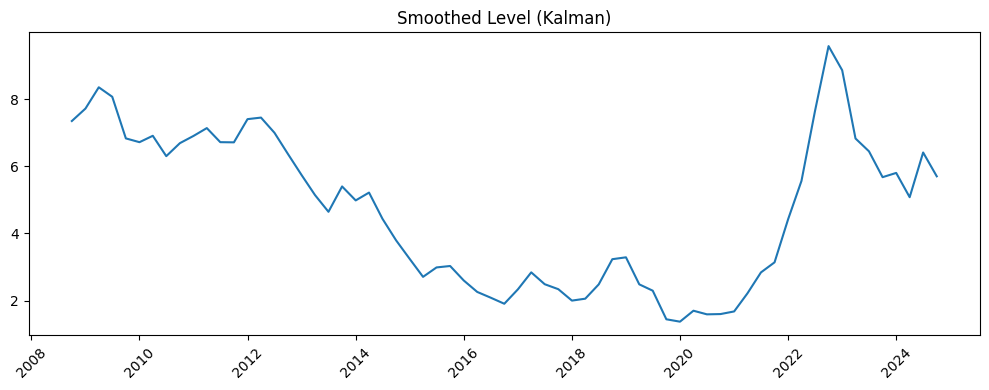

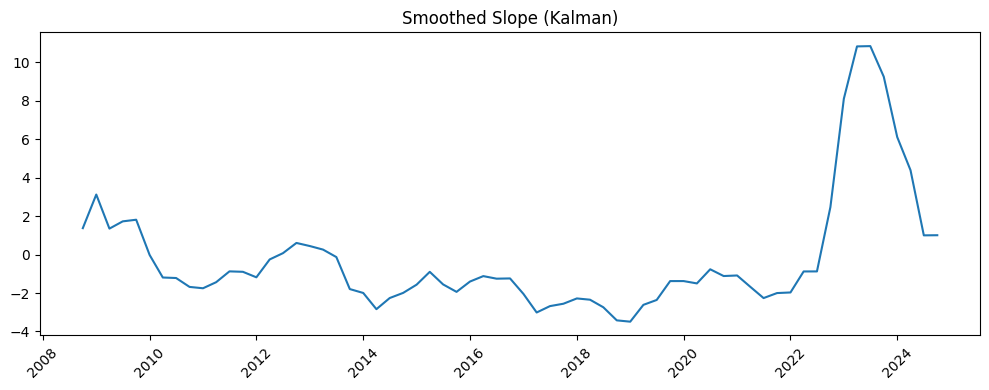

In [10]:

# Plot smoothed Level/Slope
fig = plt.figure(figsize=(10,4))
plt.plot(state_df["DATE"], state_df["Level"])
plt.title("Smoothed Level (Kalman)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,4))
plt.plot(state_df["DATE"], state_df["Slope"])
plt.title("Smoothed Slope (Kalman)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Structural identification (Reppa Table 6)

We identify shocks from a decomposition \(\Omega = SS'\) with **zero + sign restrictions at impact**.
The algorithm follows Uhlig (2005) / Reppa Appendix idea: draw orthogonal matrices and keep draws that satisfy restrictions.


In [12]:

# ----------------------
# 8) Identification setup
# ----------------------
Omega = Omega_hat
P = np.linalg.cholesky(Omega)

var_names = state_names
shock_names = ["L","S","PREM","MP","DEM","SUPP"]

# Zero restrictions (Table 6): MNB, CORE, IP do not react to L and S; CORE and IP do not react to PREM and MP
zero_restr = {
    "L":    [var_names.index("MNB"),  var_names.index("CORE"), var_names.index("IP")],
    "S":    [var_names.index("MNB"),  var_names.index("CORE"), var_names.index("IP")],
    "PREM": [var_names.index("CORE"), var_names.index("IP")],
    "MP":   [var_names.index("CORE"), var_names.index("IP")],
    "DEM":  [],
    "SUPP": [],
}

# Sign restrictions at impact (t=0)
sign_restr = {
    ("Level","L"): +1,
    ("Slope","S"): +1,

    ("MNB","PREM"): +1,
    ("HUF","PREM"): +1,

    ("MNB","MP"): +1,
    ("HUF","MP"): -1,

    ("CORE","DEM"): +1,
    ("IP","DEM"): +1,

    ("CORE","SUPP"): -1,
    ("IP","SUPP"): +1,
}


In [20]:

# ----------------------
# 9) Draw O with zero restrictions (IMPORTANT: no QR at the end)
# ----------------------
def random_orthogonal_with_zero_restr(P: np.ndarray, zero_restr: dict, shock_names: list, rng: np.random.Generator):
    n = P.shape[0]
    X = rng.standard_normal(size=(n, n))
    O = np.zeros((n, n))

    for j, sh in enumerate(shock_names):
        rows = zero_restr.get(sh, [])
        blocks = []
        if rows:
            Pj = P[rows, :]
            blocks.append(Pj.T)
        if j > 0:
            blocks.append(O[:, :j])

        if blocks:
            Aj = np.concatenate(blocks, axis=1)
            AtA = Aj.T @ Aj
            try:
                proj = Aj @ np.linalg.solve(AtA, Aj.T @ X[:, j])
            except np.linalg.LinAlgError:
                return None
            r = X[:, j] - proj
        else:
            r = X[:, j].copy()

        nr = np.linalg.norm(r)
        if nr < 1e-10:
            return None
        O[:, j] = r / nr

    return O


def check_sign_restr(S: np.ndarray, var_names: list, shock_names: list, sign_restr: dict, tol=0.0):
    for (v, sh), sgn in sign_restr.items():
        i = var_names.index(v)
        j = shock_names.index(sh)
        val = S[i, j]
        if sgn == +1 and not (val > tol):
            return False
        if sgn == -1 and not (val < -tol):
            return False
    return True


def check_zero_restr(S: np.ndarray, shock_names: list, zero_restr: dict, tol=1e-6):
    for sh, rows in zero_restr.items():
        j = shock_names.index(sh)
        for i in rows:
            if abs(S[i, j]) > tol:
                return False
    return True


rng = np.random.default_rng(123)

accepted_S = []
max_accept = 5000
max_tries = 2000000

for _ in range(max_tries):
    O = random_orthogonal_with_zero_restr(P, zero_restr, shock_names, rng)
    if O is None:
        continue
    S = P @ O
    if not check_zero_restr(S, shock_names, zero_restr):
        continue
    if not check_sign_restr(S, var_names, shock_names, sign_restr, tol=0.0):
        continue
    accepted_S.append(S)
    if len(accepted_S) >= max_accept:
        break

print("Accepted draws:", len(accepted_S), "out of", max_tries)

if not accepted_S:
    raise RuntimeError("No accepted draws - restrictions likely too tight or inconsistent for this sample.")

accepted_S[0]


Accepted draws: 3103 out of 2000000


array([[ 3.72838326e-02, -2.86809216e-01,  5.66593774e-01,
        -6.39199866e-02,  3.07999456e-01, -1.54966178e-01],
       [-4.66923108e-01,  1.18271491e-01,  5.18324136e-01,
         1.62942607e-01,  5.90973236e-01, -2.97385437e-01],
       [-4.47704817e-16,  3.78900156e-16,  2.92399723e-01,
         5.83090302e-01,  8.46055116e-01, -4.25748067e-01],
       [ 1.14696386e-01,  1.50672213e-01,  1.01466288e-03,
        -1.42054212e-01, -2.40126650e-01,  1.20858036e-01],
       [-4.04133720e-16,  4.71671013e-17, -6.69053106e-17,
         1.05268819e-17,  1.17650376e+00, -5.91222262e-01],
       [ 2.55663490e-15,  1.29000716e-14, -4.69785304e-16,
        -7.81187011e-16,  3.15407314e+01,  6.46943947e+01]])

In [21]:

# ----------------------
# 10) Impulse responses for the state vector
# ----------------------
A = F_hat  # VAR(1) transition
n = A.shape[0]
H = 24  # horizon in periods

Ak = [np.eye(n)]
for k in range(1, H+1):
    Ak.append(Ak[-1] @ A)
Ak = np.stack(Ak, axis=0)  # (H+1, n, n)

IRFs = []  # (n_draws, H+1, n_vars, n_shocks)
for S in accepted_S:
    irf = np.einsum('kij,jm->kim', Ak, S)
    IRFs.append(irf)
IRFs = np.stack(IRFs, axis=0)

print("IRFs shape:", IRFs.shape)


IRFs shape: (3103, 25, 6, 6)


In [22]:

# Helper to summarize IRFs across draws

def summarize_irf(irf_draws):
    q16 = np.quantile(irf_draws, 0.16, axis=0)
    q50 = np.quantile(irf_draws, 0.50, axis=0)
    q84 = np.quantile(irf_draws, 0.84, axis=0)
    return q16, q50, q84


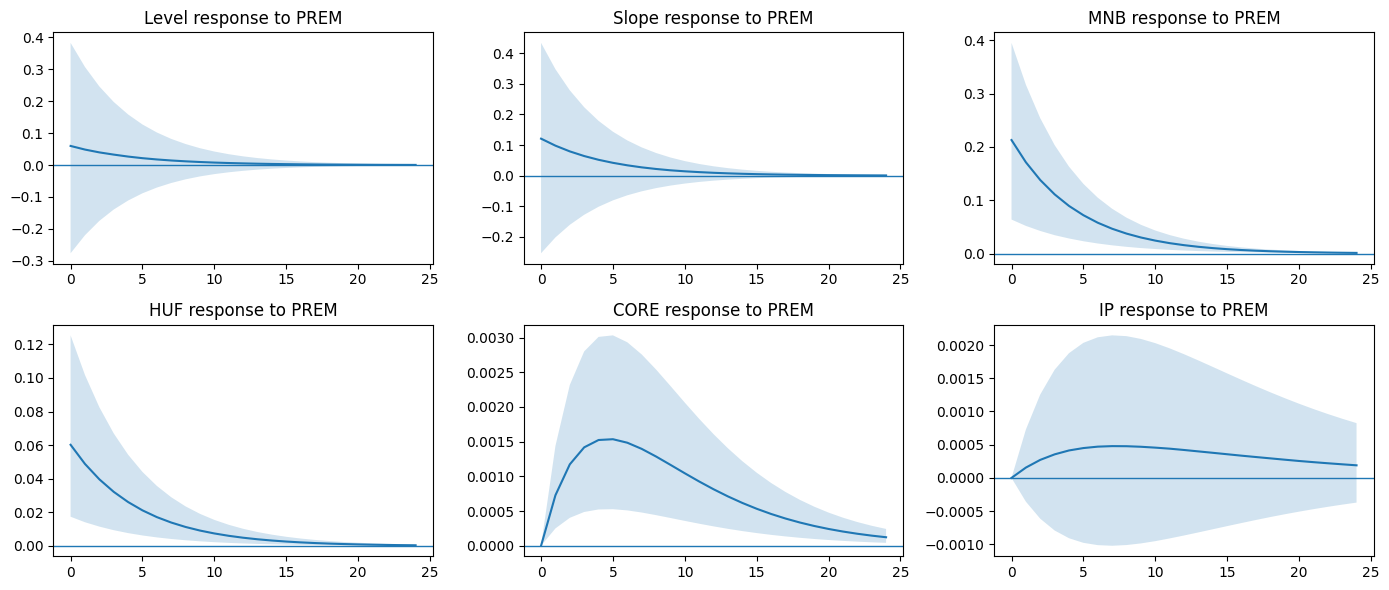

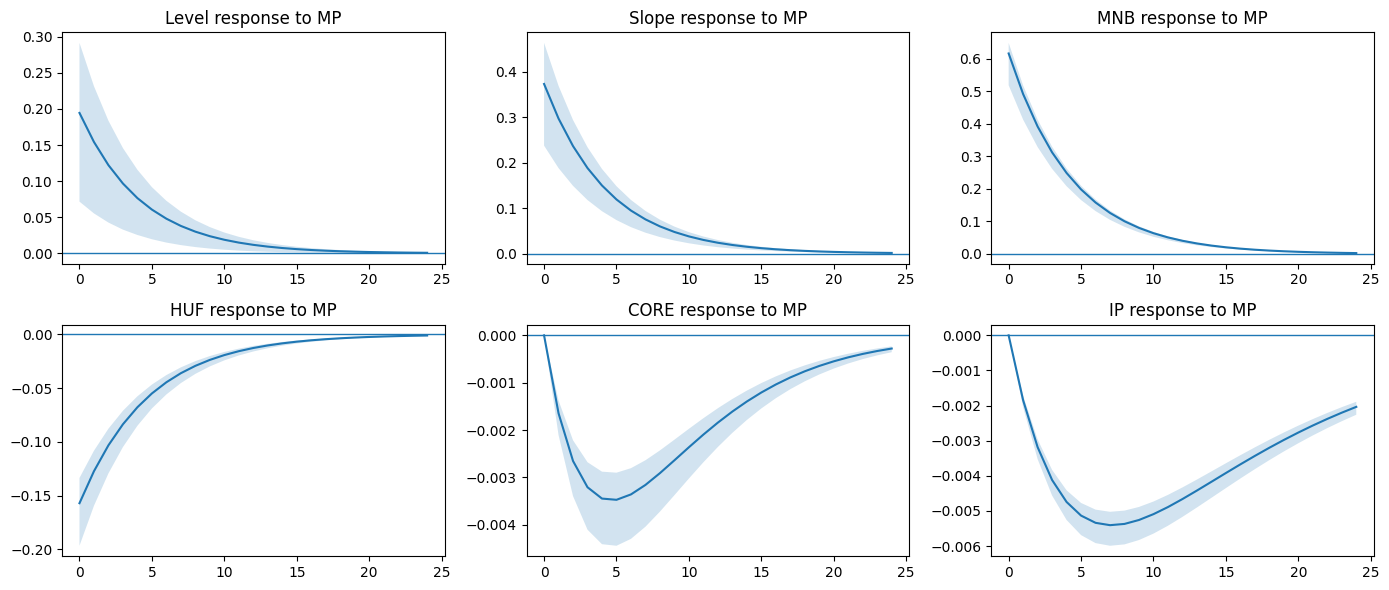

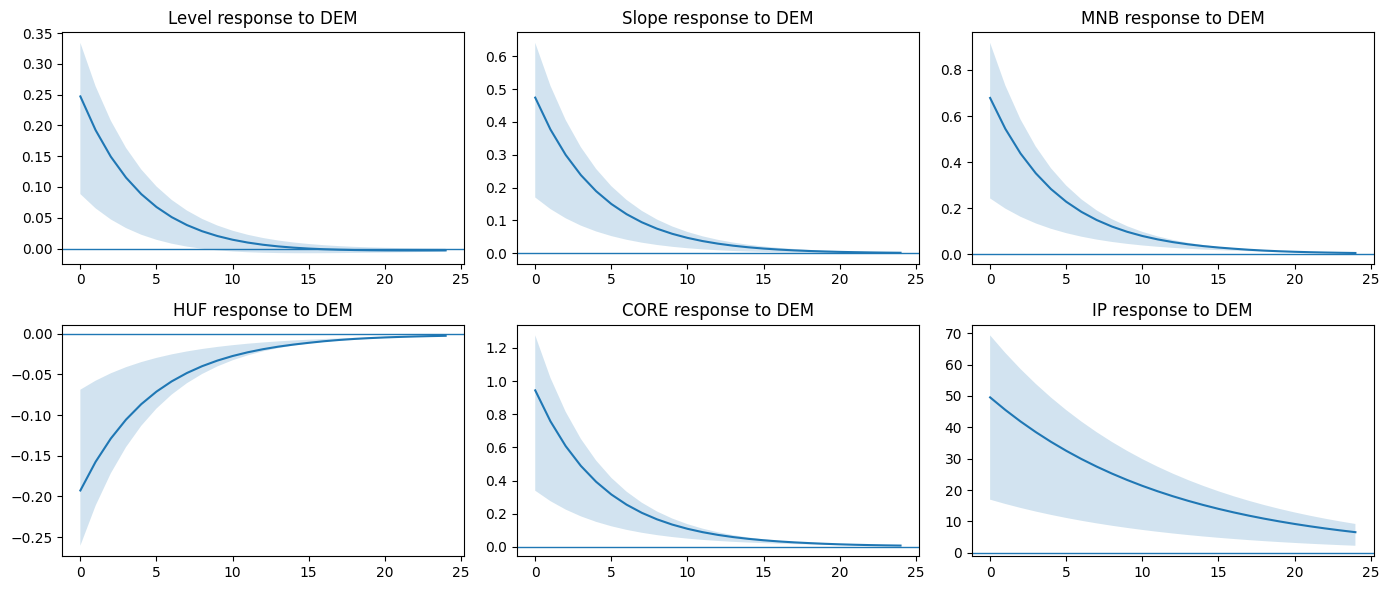

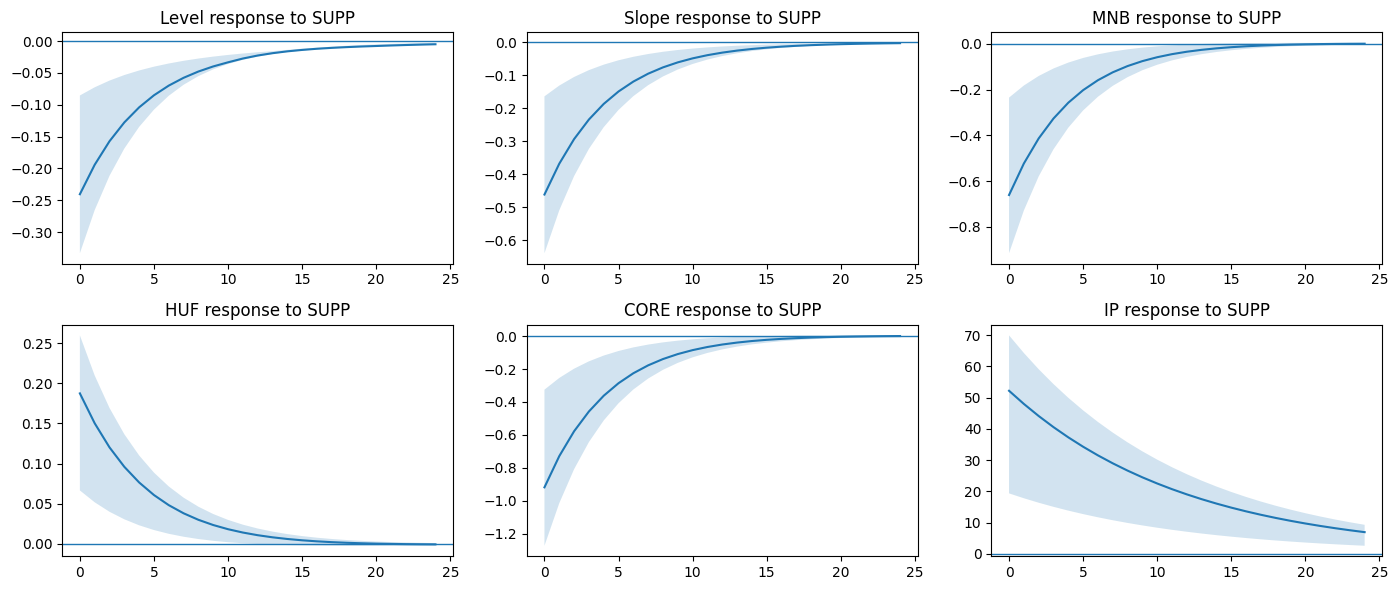

In [23]:

# Plot responses of the state variables to the four identified macro shocks
plot_vars = ["Level","Slope","MNB","HUF","CORE","IP"]
plot_shocks = ["PREM","MP","DEM","SUPP"]

h = np.arange(H+1)

for sh in plot_shocks:
    j = shock_names.index(sh)
    fig, axes = plt.subplots(2, 3, figsize=(14,6))
    axes = axes.ravel()

    for ax_i, v in enumerate(plot_vars):
        i = var_names.index(v)
        draws = IRFs[:, :, i, j]
        q16, q50, q84 = summarize_irf(draws)
        axes[ax_i].plot(h, q50)
        axes[ax_i].fill_between(h, q16, q84, alpha=0.2)
        axes[ax_i].axhline(0, linewidth=1)
        axes[ax_i].set_title(f"{v} response to {sh}")

    plt.tight_layout()
    plt.show()


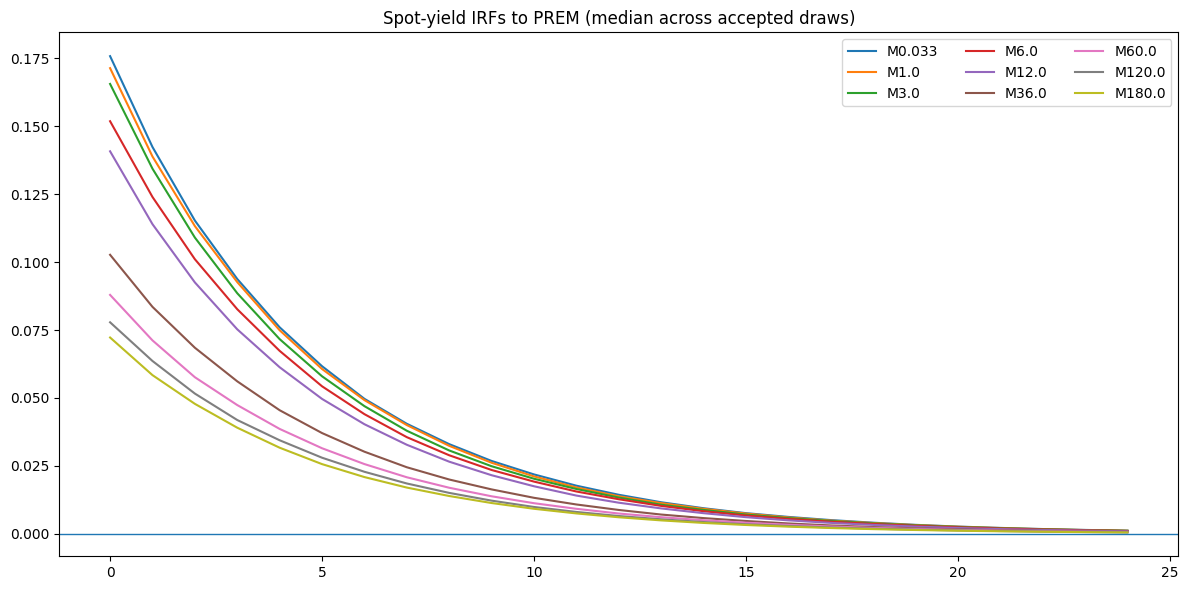

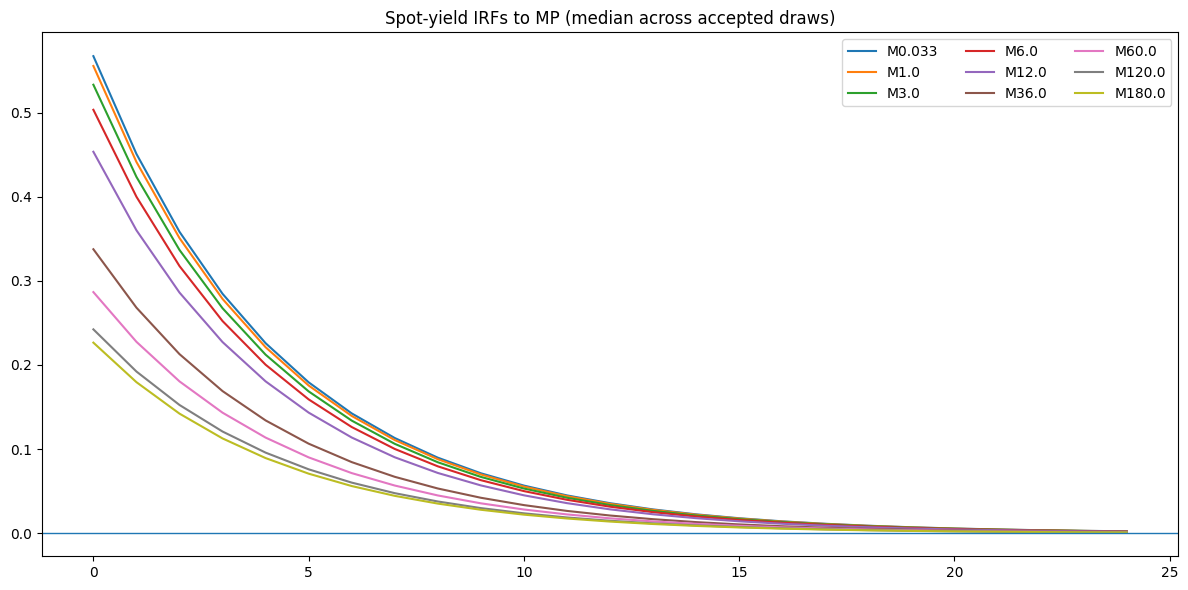

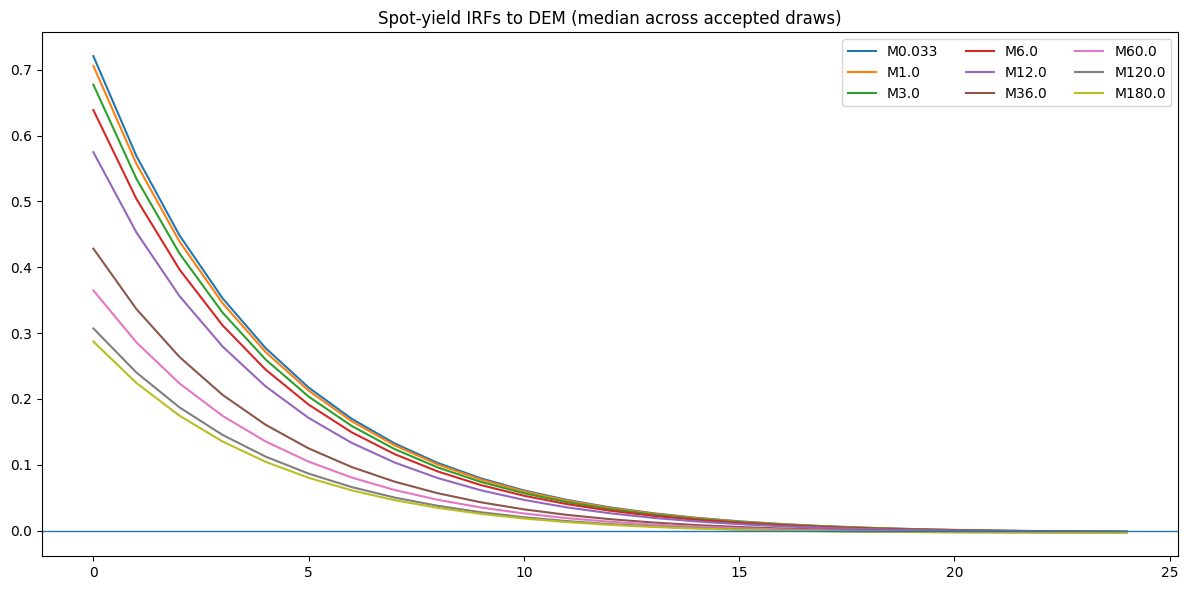

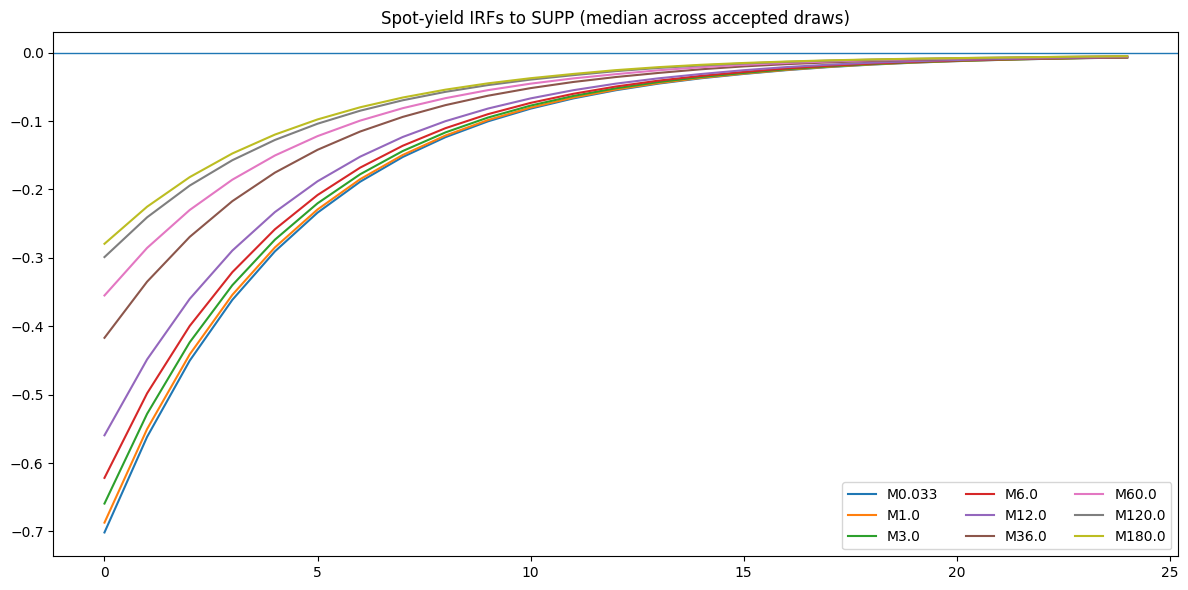

In [24]:

# ----------------------
# 11) Map factor IRFs to yield IRFs using tau_hat and maturities
# ----------------------
def yield_irf_from_factor_irfs(level_irf, slope_irf, h_months, tau_months):
    b = ns_b(np.array([h_months], dtype=float), tau_months)[0]
    return level_irf + b * slope_irf

chosen_mats = list(maturities_months)  # use available maturities
h = np.arange(H+1)

for sh in ["PREM","MP","DEM","SUPP"]:
    j = shock_names.index(sh)
    L_draws = IRFs[:, :, var_names.index("Level"), j]
    S_draws = IRFs[:, :, var_names.index("Slope"), j]

    fig = plt.figure(figsize=(12,6))
    for mat in chosen_mats:
        y_draws = np.stack([
            yield_irf_from_factor_irfs(L_draws[d], S_draws[d], mat, tau_hat)
            for d in range(L_draws.shape[0])
        ], axis=0)
        q16, q50, q84 = summarize_irf(y_draws)
        plt.plot(h, q50, label=f"M{mat}")

    plt.axhline(0, linewidth=1)
    plt.title(f"Spot-yield IRFs to {sh} (median across accepted draws)")
    plt.legend(ncol=3)
    plt.tight_layout()
    plt.show()


In [19]:
# ----------------------
# 12) FEVD (state variables) at selected horizons
# ----------------------
import numpy as np
import pandas as pd

def fevd_from_irfs(irf_matrix: np.ndarray, H: int, inclusive: bool = True) -> np.ndarray:
    """
    irf_matrix: (T, n_vars, n_shocks), typically T = H_max+1 with t=0 included
    returns: (n_vars, n_shocks) FEVD shares at horizon H
    """
    if irf_matrix.ndim != 3:
        raise ValueError(f"irf_matrix must be 3D (T,n_vars,n_shocks), got {irf_matrix.shape}")

    T, n_vars, n_shocks = irf_matrix.shape
    k_end = H if inclusive else H - 1

    if k_end < 0:
        raise ValueError("H must be >=0 (inclusive) or >=1 (exclusive)")
    if k_end >= T:
        raise ValueError(f"Need IRF length >= H+1 (inclusive). Got T={T}, H={H}")

    contrib = np.zeros((n_vars, n_shocks), dtype=float)
    total = np.zeros((n_vars,), dtype=float)

    for k in range(0, k_end + 1):
        sq = np.asarray(irf_matrix[k], dtype=float) ** 2
        contrib += sq
        total += np.sum(sq, axis=1)

    shares = np.zeros_like(contrib)
    np.divide(contrib, total[:, None], out=shares, where=(total[:, None] != 0.0))
    return shares


def fevd_over_draws(IRFs: np.ndarray, H: int, inclusive: bool = True) -> np.ndarray:
    """
    IRFs: (n_draws, T, n_vars, n_shocks)
    returns: (n_draws, n_vars, n_shocks)
    """
    if IRFs.ndim != 4:
        raise ValueError(f"IRFs must be 4D (n_draws,T,n_vars,n_shocks), got {IRFs.shape}")
    return np.stack([fevd_from_irfs(IRFs[d], H, inclusive=inclusive) for d in range(IRFs.shape[0])], axis=0)


def top_contributors_row(row: pd.Series, k: int = 3):
    s = row.sort_values(ascending=False)
    return list(zip(s.index[:k], s.values[:k]))


# --- horizons you want
horizons = [1, 8]
inclusive = True  # sum t=0..H

fevd_results = {}  # store results if you want later export

for Hh in horizons:
    # (n_draws, n_vars, n_shocks)
    shares_draws = fevd_over_draws(IRFs, Hh, inclusive=inclusive)

    # point estimates across accepted draws
    shares_mean = shares_draws.mean(axis=0)
    shares_p16  = np.quantile(shares_draws, 0.16, axis=0)
    shares_p50  = np.quantile(shares_draws, 0.50, axis=0)
    shares_p84  = np.quantile(shares_draws, 0.84, axis=0)

    fevd_mean = pd.DataFrame(shares_mean, index=var_names, columns=shock_names)
    fevd_p16  = pd.DataFrame(shares_p16,  index=var_names, columns=shock_names)
    fevd_p50  = pd.DataFrame(shares_p50,  index=var_names, columns=shock_names)
    fevd_p84  = pd.DataFrame(shares_p84,  index=var_names, columns=shock_names)

    fevd_results[Hh] = {
        "mean": fevd_mean,
        "p16": fevd_p16,
        "p50": fevd_p50,
        "p84": fevd_p84,
    }

    print(f"\nFEVD (mean across accepted draws), horizon={Hh} periods (sum t=0..{Hh})")
    display(fevd_mean.round(3))

    print(f"\nFEVD (median across accepted draws), horizon={Hh} periods (sum t=0..{Hh})")
    display(fevd_p50.round(3))

    # Quick interpretation helper: top 3 shocks per variable (based on mean FEVD)
    top3 = fevd_mean.apply(top_contributors_row, axis=1)
    top3_df = pd.DataFrame({"top3_shocks (mean FEVD)": top3}, index=var_names)
    print(f"\nTop-3 FEVD contributors per variable (mean), horizon={Hh}")
    display(top3_df)



FEVD (mean across accepted draws), horizon=1 periods (sum t=0..1)


,L,S,PREM,MP,DEM,SUPP
Level,0.264,0.267,0.161,0.084,0.117,0.107
Slope,0.160,0.146,0.104,0.137,0.238,0.215
MNB,0.000,0.000,0.060,0.262,0.358,0.320
HUF,0.070,0.083,0.060,0.225,0.297,0.266
CORE,0.000,0.000,0.000,0.000,0.527,0.473
IP,0.000,0.000,0.000,0.000,0.466,0.534



FEVD (median across accepted draws), horizon=1 periods (sum t=0..1)


,L,S,PREM,MP,DEM,SUPP
Level,0.206,0.215,0.089,0.069,0.124,0.100
Slope,0.144,0.119,0.063,0.139,0.253,0.200
MNB,0.000,0.000,0.035,0.287,0.381,0.297
HUF,0.041,0.056,0.030,0.210,0.317,0.246
CORE,0.000,0.000,0.000,0.000,0.561,0.439
IP,0.000,0.000,0.000,0.000,0.429,0.571



Top-3 FEVD contributors per variable (mean), horizon=1


,top3_shocks (mean FEVD)
Level,"[(S, 0.2672795176880816), (L, 0.26352374745394..."
Slope,"[(DEM, 0.23794538025275672), (SUPP, 0.21498398..."
MNB,"[(DEM, 0.3577580638275881), (SUPP, 0.320349181..."
HUF,"[(DEM, 0.29739945286293556), (SUPP, 0.26552853..."
CORE,"[(DEM, 0.5274462431852376), (SUPP, 0.472551381..."
IP,"[(SUPP, 0.5341472554961163), (DEM, 0.465852743..."



FEVD (mean across accepted draws), horizon=8 periods (sum t=0..8)


,L,S,PREM,MP,DEM,SUPP
Level,0.265,0.269,0.162,0.083,0.111,0.110
Slope,0.161,0.147,0.105,0.136,0.236,0.215
MNB,0.000,0.000,0.061,0.261,0.363,0.315
HUF,0.070,0.083,0.060,0.225,0.303,0.259
CORE,0.000,0.000,0.000,0.000,0.533,0.467
IP,0.000,0.000,0.000,0.000,0.466,0.534



FEVD (median across accepted draws), horizon=8 periods (sum t=0..8)


,L,S,PREM,MP,DEM,SUPP
Level,0.206,0.217,0.091,0.068,0.116,0.106
Slope,0.146,0.120,0.063,0.137,0.251,0.200
MNB,0.000,0.000,0.036,0.287,0.388,0.289
HUF,0.041,0.056,0.030,0.210,0.326,0.237
CORE,0.000,0.000,0.000,0.000,0.570,0.430
IP,0.000,0.000,0.000,0.000,0.429,0.571



Top-3 FEVD contributors per variable (mean), horizon=8


,top3_shocks (mean FEVD)
Level,"[(S, 0.26883739951028707), (L, 0.2651158888482..."
Slope,"[(DEM, 0.2360608499218673), (SUPP, 0.214679412..."
MNB,"[(DEM, 0.3626340060472823), (SUPP, 0.314983653..."
HUF,"[(DEM, 0.30325162716588844), (SUPP, 0.25886440..."
CORE,"[(DEM, 0.5329657760436551), (SUPP, 0.466995152..."
IP,"[(SUPP, 0.5342294982765939), (DEM, 0.465770492..."
